# Discussion section analysis

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2

%load_ext rpy2.ipython
%matplotlib inline

In [2]:
reg_palette = sns.color_palette("colorblind", 5)[2:]
sns.set_palette(reg_palette)
sns.set_style("whitegrid")

## Changing granularity

In [3]:
df = pd.read_csv("../data/discussion-granularity-error.csv", index_col=0)
df

,User ID,Technique,Skill,Background,Training,Granularity,Error rate
0,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,No-Music,Untrained,Error rate 12,7.692308
1,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,No-Music,Untrained,Error rate 7,7.692308
2,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,No-Music,Untrained,Error rate 3,0.000000
3,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Music,Untrained,Error rate 12,0.000000
4,4g4XbueBXPakEKcHYSqqot76sGg1,Pitch,Expert,Music,Untrained,Error rate 7,0.000000
...,...,...,...,...,...,...,...
751,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,No-Music,Trained,Error rate 7,0.000000
752,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,No-Music,Trained,Error rate 3,0.000000
753,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Music,Trained,Error rate 12,7.142857
754,RIneOAfWA6POfHcHOoYEDG1BF6T2,Melody,Expert,Music,Trained,Error rate 7,7.142857


In [38]:
%%R -i df

library(ARTool) # art, artlm

# Sanitize dataframe column names
library(janitor)
df <- clean_names(df)

df$technique <- factor(df$technique)
df$skill <- factor(df$skill)
df$background <- factor(df$background)
df$training <- factor(df$training)
df$granularity <- factor(df$granularity)
df$user_id <- factor(df$user_id)

### Pitch: Skill X Granularity ANOVA

In [5]:
%%R
pitch_df <- subset(df, technique == "Pitch")
pitch_df_art <- art(error_rate ~ skill * granularity + Error(user_id / granularity) + skill, data = pitch_df)
summary(pitch_df_art)

Aligned Rank Transform of Factorial Model

Call:
art(formula = error_rate ~ skill * granularity + Error(user_id/granularity) + 
    skill, data = pitch_df)

Column sums of aligned responses (should all be ~0):
            skill       granularity skill:granularity 
                0                 0                 0 

F values of ANOVAs on aligned responses not of interest (should all be ~0):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


In [6]:
%%R
m = anova(pitch_df_art)
m$eta.sq.part = with(m, `Sum Sq`/(`Sum Sq` + `Sum Sq.res`))
print(m)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Repeated Measures Analysis of Variance Table (Type I) 
Model: Repeated Measures (aov)
Response: art(error_rate)

                    Error Df Df.res F value     Pr(>F) eta.sq.part    
1 skill             usr_d  2     18  36.877 4.3034e-07     0.80382 ***
2 granularity       usr_:  2     36 115.131 2.2796e-16     0.86480 ***
3 skill:granularity usr_:  4     36  27.785 1.4403e-10     0.75534 ***
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


#### Pitch post-hoc: Granularity

In [7]:
%%R
suppressMessages(art.con(pitch_df_art, ~ granularity, interaction = FALSE))

 contrast                     estimate   SE df t.ratio p.value
 Error rate 12 - Error rate 3     47.7 3.37 36  14.164  <.0001
 Error rate 12 - Error rate 7     12.2 3.37 36   3.622  0.0025
 Error rate 3 - Error rate 7     -35.5 3.37 36 -10.542  <.0001

Results are averaged over the levels of: skill 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [8]:
df[(df["Technique"] == "Pitch")].groupby(["Granularity"]).mean()

,Error rate
Granularity,
Error rate 12,34.147698
Error rate 3,19.801587
Error rate 7,29.934153


#### Pitch post-hoc: Skill X Granularity

In [9]:
%%R
suppressMessages(art.con(pitch_df_art, ~ skill * granularity, interaction = TRUE))

 skill_pairwise        granularity_pairwise         estimate   SE df t.ratio
 Expert - Intermediate Error rate 12 - Error rate 3   -56.07 8.88 36  -6.317
 Expert - Novice       Error rate 12 - Error rate 3   -84.07 8.51 36  -9.883
 Intermediate - Novice Error rate 12 - Error rate 3   -27.99 9.14 36  -3.061
 Expert - Intermediate Error rate 12 - Error rate 7   -21.65 8.88 36  -2.439
 Expert - Novice       Error rate 12 - Error rate 7   -20.33 8.51 36  -2.390
 Intermediate - Novice Error rate 12 - Error rate 7     1.32 9.14 36   0.144
 Expert - Intermediate Error rate 3 - Error rate 7     34.43 8.88 36   3.878
 Expert - Novice       Error rate 3 - Error rate 7     63.74 8.51 36   7.493
 Intermediate - Novice Error rate 3 - Error rate 7     29.31 9.14 36   3.205
 p.value
  <.0001
  <.0001
  0.0042
  0.0198
  0.0222
  0.8864
  0.0004
  <.0001
  0.0028



In [10]:
df[(df["Technique"] == "Pitch")].groupby(["Skill", "Granularity"]).mean()

Error rate
Skill        Granularity              
Expert       Error rate 12   10.602679
             Error rate 3     6.041667
             Error rate 7     8.762592
Intermediate Error rate 12   35.805861
             Error rate 3    20.833333
             Error rate 7    29.830586
Novice       Error rate 12   59.635008
             Error rate 3    34.642857
             Error rate 7    54.218995

### Interval: Skill X Granularity ANOVA

In [11]:
%%R
interval_df <- subset(df, technique == "Interval")
interval_df_art <- art(error_rate ~ skill * granularity + Error(user_id / granularity) + skill, data = interval_df)
summary(interval_df_art)

Aligned Rank Transform of Factorial Model

Call:
art(formula = error_rate ~ skill * granularity + Error(user_id/granularity) + 
    skill, data = interval_df)

Column sums of aligned responses (should all be ~0):
            skill       granularity skill:granularity 
                0                 0                 0 

F values of ANOVAs on aligned responses not of interest (should all be ~0):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


In [12]:
%%R
m = anova(interval_df_art)
m$eta.sq.part = with(m, `Sum Sq`/(`Sum Sq` + `Sum Sq.res`))
print(m)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Repeated Measures Analysis of Variance Table (Type I) 
Model: Repeated Measures (aov)
Response: art(error_rate)

                    Error Df Df.res F value     Pr(>F) eta.sq.part    
1 skill             usr_d  2     18 15.8370 0.00010772     0.63764 ***
2 granularity       usr_:  2     36 40.4384 6.2278e-10     0.69198 ***
3 skill:granularity usr_:  4     36  6.9938 0.00028392     0.43728 ***
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


#### Interval post-hoc: Granularity

In [13]:
%%R
suppressMessages(art.con(interval_df_art, ~ granularity, interaction = FALSE))

 contrast                     estimate   SE df t.ratio p.value
 Error rate 12 - Error rate 3     43.2 5.03 36   8.599  <.0001
 Error rate 12 - Error rate 7     17.3 5.03 36   3.449  0.0040
 Error rate 3 - Error rate 7     -25.9 5.03 36  -5.150  <.0001

Results are averaged over the levels of: skill 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [14]:
df[(df["Technique"] == "Interval")].groupby(["Granularity"]).mean()

,Error rate
Granularity,
Error rate 12,28.736046
Error rate 3,19.642857
Error rate 7,24.438557


#### Interval post-hoc: Skill X Granularity

In [15]:
%%R
suppressMessages(art.con(interval_df_art, ~ skill * granularity, interaction = TRUE))

 skill_pairwise        granularity_pairwise         estimate   SE df t.ratio
 Expert - Intermediate Error rate 12 - Error rate 3   -54.66 12.2 36  -4.492
 Expert - Novice       Error rate 12 - Error rate 3   -52.05 11.7 36  -4.464
 Intermediate - Novice Error rate 12 - Error rate 3     2.61 12.5 36   0.208
 Expert - Intermediate Error rate 12 - Error rate 7   -29.21 12.2 36  -2.400
 Expert - Novice       Error rate 12 - Error rate 7   -22.46 11.7 36  -1.927
 Intermediate - Novice Error rate 12 - Error rate 7     6.74 12.5 36   0.538
 Expert - Intermediate Error rate 3 - Error rate 7     25.45 12.2 36   2.091
 Expert - Novice       Error rate 3 - Error rate 7     29.58 11.7 36   2.537
 Intermediate - Novice Error rate 3 - Error rate 7      4.14 12.5 36   0.330
 p.value
  0.0001
  0.0001
  0.8364
  0.0217
  0.0620
  0.5939
  0.0436
  0.0157
  0.7433



In [16]:
df[(df["Technique"] == "Interval")].groupby(["Skill", "Granularity"]).mean()

Error rate
Skill        Granularity              
Expert       Error rate 12    8.364812
             Error rate 3     6.770833
             Error rate 7     7.454785
Intermediate Error rate 12   30.059524
             Error rate 3    15.972222
             Error rate 7    22.527473
Novice       Error rate 12   50.883046
             Error rate 3    37.500000
             Error rate 7    45.486656

### Melody: Skill X Granularity ANOVA

In [17]:
%%R
melody_df <- subset(df, technique == "Melody")
melody_df_art <- art(error_rate ~ skill * granularity + Error(user_id / granularity) + skill, data = melody_df)
summary(melody_df_art)

Aligned Rank Transform of Factorial Model

Call:
art(formula = error_rate ~ skill * granularity + Error(user_id/granularity) + 
    skill, data = melody_df)

Column sums of aligned responses (should all be ~0):
            skill       granularity skill:granularity 
                0                 0                 0 

F values of ANOVAs on aligned responses not of interest (should all be ~0):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


In [18]:
%%R
m = anova(melody_df_art)
m$eta.sq.part = with(m, `Sum Sq`/(`Sum Sq` + `Sum Sq.res`))
print(m)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Repeated Measures Analysis of Variance Table (Type I) 
Model: Repeated Measures (aov)
Response: art(error_rate)

                    Error Df Df.res F value     Pr(>F) eta.sq.part    
1 skill             usr_d  2     18 46.1714 8.1800e-08     0.83687 ***
2 granularity       usr_:  2     36 44.0472 2.1179e-10     0.70990 ***
3 skill:granularity usr_:  4     36  8.8327 4.4748e-05     0.49531 ***
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


#### Melody post-hoc: Granularity

In [19]:
%%R
suppressMessages(art.con(melody_df_art, ~ granularity, interaction = FALSE))

 contrast                     estimate   SE df t.ratio p.value
 Error rate 12 - Error rate 3    60.02 7.25 36   8.280  <.0001
 Error rate 12 - Error rate 7     4.57 7.25 36   0.630  0.8048
 Error rate 3 - Error rate 7    -55.46 7.25 36  -7.650  <.0001

Results are averaged over the levels of: skill 
P value adjustment: tukey method for comparing a family of 3 estimates 


In [20]:
df[(df["Technique"] == "Melody")].groupby(["Granularity"]).mean()

,Error rate
Granularity,
Error rate 12,27.532487
Error rate 3,14.642857
Error rate 7,26.826051


#### Melody post-hoc: Skill X Granularity

In [21]:
%%R
suppressMessages(art.con(melody_df_art, ~ skill * granularity, interaction = TRUE))

 skill_pairwise        granularity_pairwise         estimate   SE df t.ratio
 Expert - Intermediate Error rate 12 - Error rate 3    -66.0 18.3 36  -3.604
 Expert - Novice       Error rate 12 - Error rate 3    -94.4 17.6 36  -5.379
 Intermediate - Novice Error rate 12 - Error rate 3    -28.4 18.9 36  -1.505
 Expert - Intermediate Error rate 12 - Error rate 7    -18.0 18.3 36  -0.983
 Expert - Novice       Error rate 12 - Error rate 7    -14.6 17.6 36  -0.832
 Intermediate - Novice Error rate 12 - Error rate 7      3.4 18.9 36   0.180
 Expert - Intermediate Error rate 3 - Error rate 7      48.0 18.3 36   2.621
 Expert - Novice       Error rate 3 - Error rate 7      79.8 17.6 36   4.547
 Intermediate - Novice Error rate 3 - Error rate 7      31.8 18.9 36   1.686
 p.value
  0.0009
  <.0001
  0.1409
  0.3320
  0.4106
  0.8581
  0.0128
  0.0001
  0.1005



In [22]:
df[(df["Technique"] == "Melody")].groupby(["Skill", "Granularity"]).mean()

Error rate
Skill        Granularity              
Expert       Error rate 12    7.214400
             Error rate 3     2.604167
             Error rate 7     7.660829
Intermediate Error rate 12   24.587912
             Error rate 3    11.805556
             Error rate 7    23.099817
Novice       Error rate 12   53.277080
             Error rate 3    30.833333
             Error rate 7    51.923077

### Granularity graphs

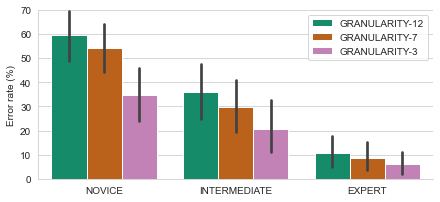

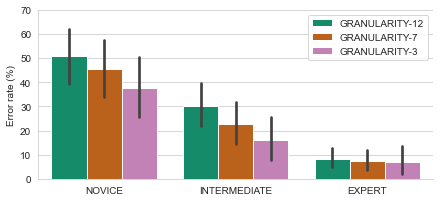

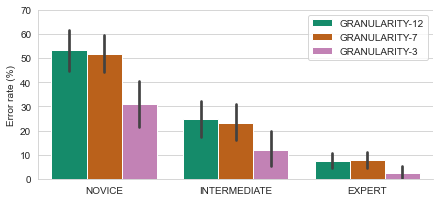

In [23]:
from utils.factorize import factorize_xticks, wrap_dv, wrap_factor

skills = ["Novice", "Intermediate", "Expert"]
techniques = ["Pitch", "Interval", "Melody"]
legend_labels = [
    wrap_factor(x) for x in ["granularity-12", "granularity-7", "granularity-3"]
]

for technique in techniques:
    fig = plt.figure(constrained_layout=True)
    fig.set_figwidth(6)
    fig.set_figheight(2.7)
    ax = fig.add_subplot()
    curr_df = df[(df["Technique"] == technique)]
    sns.barplot(
        data=curr_df,
        x="Skill",
        order=skills,
        y="Error rate",
        hue="Granularity",
        ci=95,
        n_boot=10000,
        ax=ax,
        palette=reg_palette,
    )

    ax.set_xlabel(None)
    factorize_xticks(ax)
    ax.set_ylim(ymin=0, ymax=70)
    ax.set_ylabel("Error rate (%)")

    for idx, text in enumerate(ax.legend().get_texts()):
        text.set_text(legend_labels[idx])

    # Remove spines
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

## Melody confusion matrix

In [24]:
mel_df = pd.read_csv("../data/discussion-melody-confusion.csv", index_col=0)
mel_df

,User ID,Skill,Training,Background,Recognized,Target,Correct
0,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,No-Music,1-3-2,1-3-2,True
1,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,No-Music,1-5-3,1-5-3,True
2,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,No-Music,1-3-5,1-3-5,True
3,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,No-Music,1-5-8,1-5-8,True
4,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,No-Music,1-2-3,1-2-3,True
...,...,...,...,...,...,...,...
1155,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Trained,Music,1-3-5,1-3-5,True
1156,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Trained,Music,1-3-5,1-3-2,False
1157,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Trained,Music,1-2-3,1-2-3,True
1158,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Trained,Music,1-2-3,1-2-3,True


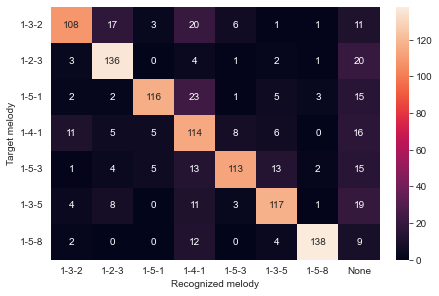

In [25]:
idx_dict = {
    "1-3-2": 0,
    "1-2-3": 1,
    "1-5-1": 2,
    "1-4-1": 3,
    "1-5-3": 4,
    "1-3-5": 5,
    "1-5-8": 6,
}
idx_keys = idx_dict.keys();
def get_melody_id(melody):
    if melody in idx_keys:
        return idx_dict[melody]
    return 7

arr = np.zeros((7, 8), np.int32)
for idx, row in mel_df.iterrows():
    arr[idx_dict[row["Target"]], get_melody_id(row["Recognized"])] += 1

melody_opts = list(idx_dict.keys())
confusion_mat = pd.DataFrame(
    data=arr, columns=melody_opts + ["None"], index=(melody_opts)
)
confusion_mat.rename_axis("Target melody", inplace=True)
confusion_mat.rename_axis("Recognized melody", axis=1, inplace=True)

fig = plt.figure(constrained_layout=True)
fig.set_figwidth(6)
fig.set_figheight(4)
ax = fig.add_subplot()
sns.heatmap(confusion_mat, annot=True, ax=ax, fmt="d")
ax.tick_params(axis="y", rotation=0)

## Changing Melodies

In [26]:
err_df = pd.read_csv("../data/discussion-melody-error.csv", index_col=0)
err_df

,User ID,Skill,Training,Background,Melodies,Error rate
0,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,No-Music,melodies-7,35.714286
1,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,No-Music,melodies-4,50.000000
2,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,Music,melodies-7,0.000000
3,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Untrained,Music,melodies-4,0.000000
4,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,Trained,No-Music,melodies-7,0.000000
...,...,...,...,...,...,...
163,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Untrained,Music,melodies-4,12.500000
164,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Trained,No-Music,melodies-7,0.000000
165,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Trained,No-Music,melodies-4,0.000000
166,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Trained,Music,melodies-7,7.142857


In [27]:
%%R -i err_df

library(ARTool) # art, artlm

# Sanitize dataframe column names
library(janitor)
err_df <- clean_names(err_df)

err_df$skill <- factor(err_df$skill)
err_df$training <- factor(err_df$training)
err_df$background <- factor(err_df$background)
err_df$user_id <- factor(err_df$user_id)
err_df$melodies <- factor(err_df$melodies)

### Melody: Skill X Melodies ANOVA

In [28]:
%%R
df_art <- art(error_rate ~ skill * melodies + Error(user_id / (melodies)) + skill, data = err_df)
summary(df_art)

Aligned Rank Transform of Factorial Model

Call:
art(formula = error_rate ~ skill * melodies + Error(user_id/(melodies)) + 
    skill, data = err_df)

Column sums of aligned responses (should all be ~0):
         skill       melodies skill:melodies 
             0              0              0 

F values of ANOVAs on aligned responses not of interest (should all be ~0):
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       0       0       0       0       0 


In [29]:
%%R
m = anova(df_art)
m$eta.sq.part = with(m, `Sum Sq`/(`Sum Sq` + `Sum Sq.res`))
print(m)

Analysis of Variance of Aligned Rank Transformed Data

Table Type: Repeated Measures Analysis of Variance Table (Type I) 
Model: Repeated Measures (aov)
Response: art(error_rate)

                 Error Df Df.res F value     Pr(>F) eta.sq.part    
1 skill          usr_d  2     18 50.6106 4.0763e-08     0.84902 ***
2 melodies       usr_:  1     18 42.2105 4.1395e-06     0.70105 ***
3 skill:melodies usr_:  2     18  6.0171  0.0099746     0.40069  **
---
Signif. codes:   0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 


#### Melody post-hoc: Melodies

In [30]:
%%R
suppressMessages(art.con(df_art, ~ melodies, interaction = FALSE))

 contrast                    estimate   SE df t.ratio p.value
 (melodies-4) - (melodies-7)    -26.5 4.19 18  -6.325  <.0001

Results are averaged over the levels of: skill 


In [31]:
err_df.groupby(["Melodies"]).mean()

,Error rate
Melodies,
melodies-4,20.386905
melodies-7,27.532487


#### Melody post-hoc: Skill X Melodies

In [32]:
%%R
suppressMessages(art.con(df_art, ~ skill * melodies, interaction = TRUE))

 skill_pairwise        melodies_pairwise           estimate   SE df t.ratio
 Expert - Intermediate (melodies-4) - (melodies-7)     16.2 11.8 18   1.368
 Expert - Novice       (melodies-4) - (melodies-7)     39.3 11.3 18   3.463
 Intermediate - Novice (melodies-4) - (melodies-7)     23.1 12.2 18   1.893
 p.value
  0.1880
  0.0028
  0.0745



In [33]:
err_df.groupby(["Skill", "Melodies"]).mean()

Error rate
Skill        Melodies              
Expert       melodies-4    3.515625
             melodies-7    7.214400
Intermediate melodies-4   21.056548
             melodies-7   24.587912
Novice       melodies-4   39.094388
             melodies-7   53.277080

### Melodies graph

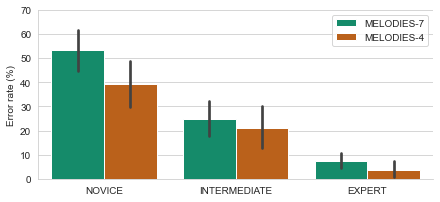

In [34]:
from utils.factorize import factorize_xticks, wrap_dv, wrap_factor

skills = ["Novice", "Intermediate", "Expert"]

fig = plt.figure(constrained_layout=True)
fig.set_figwidth(6)
fig.set_figheight(2.7)
ax = fig.add_subplot()
curr_df = err_df
sns.barplot(
    data=curr_df,
    x="Skill",
    order=skills,
    y="Error rate",
    hue="Melodies",
    #     hue_order=[7, 4],
    ci=95,
    n_boot=10000,
    ax=ax,
    palette=reg_palette,
)

ax.set_xlabel(None)
factorize_xticks(ax)

ax.set_ylim(ymin=0, ymax=70)
ax.set_ylabel("Error rate (%)")

for idx, text in enumerate(ax.legend().get_texts()):
    text.set_text(wrap_factor(text.get_text()))

# Remove spines
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

## Pitch heatmap

In [35]:
freq_df = pd.read_csv("../data/discussion-pitch-semitones.csv", index_col=0)
freq_df

,User ID,Skill,Background,Training,Success,Recognized pitch,Time,Semitones from target
0,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,No-Music,Untrained,True,32,0.000000,-0.301919
1,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,No-Music,Untrained,True,32,0.010670,-0.268139
2,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,No-Music,Untrained,True,32,0.021598,-0.351927
3,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,No-Music,Untrained,True,32,0.032225,-0.360537
4,4g4XbueBXPakEKcHYSqqot76sGg1,Expert,No-Music,Untrained,True,32,0.042874,-0.364844
...,...,...,...,...,...,...,...,...
33906,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Music,Trained,True,30,0.875828,0.228205
33907,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Music,Trained,True,30,0.906090,0.300145
33908,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Music,Trained,True,30,0.937414,0.307353
33909,RIneOAfWA6POfHcHOoYEDG1BF6T2,Expert,Music,Trained,True,30,0.968801,0.368388


In [36]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

gradient_map = LinearSegmentedColormap(
    "test",
    {
        "red": [
            (0, 1, 1),
            (0.1, 1, 1),
            (0.5, 1, 1),
            (0.75, 0.6, 0.6),
            (1, 0, 0),
        ],
        "green": [
            (0, 0.96, 0.96),
            (0.1, 0.80, 0.80),
            (0.5, 0.16, 0.16),
            (0.75, 0, 0),
            (1, 0, 0),
        ],
        "blue": [
            (0, 0.9, 0.9),
            (0.1, 0.0, 0.0),
            (0.5, 0, 0),
            (0.75, 1, 1),
            (1, 0, 0),
        ],
    },
)

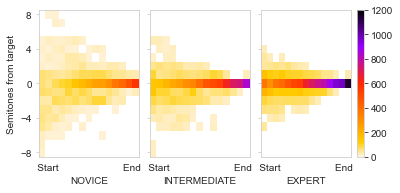

In [37]:
import matplotlib.ticker as ticker

bins = [x + 0.5 for x in range(-20, 19)]

skills = ["Novice", "Intermediate", "Expert"]

sns.set_style("white", {"axes.edgecolor": ".8"})
fig = plt.figure(6)
fig.set_figheight(2.7)
gs = fig.add_gridspec(ncols=3, nrows=1, width_ratios=[2, 2, 2.25], wspace=0.1)

for col, skill in enumerate(skills):
    curr_df = pd.DataFrame(
        freq_df[
            (freq_df["Skill"] == skill)
            & (abs(freq_df["Semitones from target"]) <= 20.5)
        ]
    )

    ax = fig.add_subplot(gs[0, col])
    sns.histplot(
        x="Time",
        y="Semitones from target",
        bins=(15, bins),
        data=curr_df,
        cbar=(col == 2),
        vmin=0,
        vmax=1200,
        pthresh=0.05,
        cmap=gradient_map,
        ax=ax,
    )
    ax.set(xlim=(0, 1), ylim=(-8.5, 8.5))
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["       Start", "End     "])
    ax.set_xlabel(wrap_factor(skill))
    ax.tick_params(axis="y", left=True, color="#CCCCCC")

    ax.yaxis.set_major_locator(ticker.MultipleLocator(4))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    if col > 0:
        ax.set_yticklabels([])
        ax.set_ylabel(None)